In [1]:
import pandas as pd
import numpy as np
import time

In [40]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings[ratings.userId==1].head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [3]:
movies = pd.read_csv('./ml-latest/movies.csv', encoding='latin-1')
print (movies.shape)
movies.head()

(58098, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
num_users = ratings.userId.unique().shape[0]
num_items = ratings.movieId.unique().shape[0]
num_users, num_items

(610, 9724)

In [5]:
from sklearn import model_selection as ms
train_set, test_set = ms.train_test_split(ratings, test_size=0.25)
len(train_set), len(test_set)

(75627, 25209)

In [6]:
UM_matrix_ds = ratings.pivot(index='userId', columns='movieId', values='rating')
print("UM Matrix value size", UM_matrix_ds.values.size)
print("ratings value size", ratings.values.size)
print("Sparisity: {:4.2f}%".format(ratings.rating.values.size/UM_matrix_ds.values.size*100))
UM_matrix_ds.head(10)

UM Matrix value size 5931640
ratings value size 403344
Sparisity: 1.70%


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,5.0,4.0,4.0,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# similarity
import math
from operator import itemgetter
from scipy.spatial import distance

def distance_cosine(a,b):
    return 1-distance.cosine(a,b)

def disance_corr(a,b):
    return 1-distance.correlation(a,b)

def distance_euclidean(a,b):
    return 1/(distance.euclidean(a,b)+1)

In [9]:
def nearest_neighbor_user(user, topN, simFunc) :  
    u1 = UM_matrix_ds.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    # Brute-Force Compute
    for uid, row in UM_matrix_ds.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        if uid==user:
            continue
            
        for i in ratedIndex:
            if False==math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3 :
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[uid] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [10]:
def nearest_neighbor_item(movie, topN, simFunc):
    m1 = UM_matrix_ds[movie].dropna()
    user_index = m1.index
    nn = {}
    
    for movieId, col in UM_matrix_ds.iteritems():
        interSectionU1 = []
        interSectionU2 = []
        if movie == movieId:
            continue
        
        for i in user_index:
            if False==math.isnan(col[i]):
                interSectionU1.append(m1[i])
                interSectionU2.append(col[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3:
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[movieId] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [41]:
print(pd.DataFrame(nearest_neighbor_user(278, 100, distance_euclidean), columns=['userId', 'sim']).head())
print(pd.DataFrame(nearest_neighbor_item(1, 100, distance_euclidean), columns=['movieId', 'sim']).head())

   userId  sim
0       8  1.0
1      15  1.0
2     348  1.0
3     352  1.0
4     373  1.0
   movieId  sim
0     1484  1.0
1     2932  1.0
2     2940  1.0
3     2967  1.0
4     2988  1.0


In [12]:
def predictRating(id_num, nn=50, simFunc=distance_euclidean, kind = 'user') :
   
    if (kind == "user"):
        ## neighboorhood 
        neighbor = nearest_neighbor_user(id_num, nn, simFunc)

        neighbor_id = [id for id, sim in neighbor]
        # List of similar similarities

        ## Remove if two or more are NaN
        neighbor_movie = UM_matrix_ds.loc[neighbor_id].dropna(1, how = 'all', thresh = 2)
        # User id x DataFrame of movie id. However, if the NaN of the column is 2 or more, it is deleted.

        neighbor_dic = dict(neighbor)
        ret = [] 
        #['movieId', 'predictedRate']

        # iterate through each column key: userid, column: movieid, value: rating
        for movieId, row in neighbor_movie.iteritems():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0],0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([movieId, wsum/jsum])

        return ret
    
    elif (kind == 'item'):
        neighbor = nearest_neighbor_item(id_num, nn, simFunc)
        
        neighbor_id = [id for id, sim in neighbor]
        
        neighbor_ratedUser = UM_matrix_ds[neighbor_id].dropna(0, how = 'all', thresh = 2)
        
        neighbor_dic = dict(neighbor)
        ret = []
        
        for userId, row in neighbor_ratedUser.iterrows():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0], 0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([userId, wsum/jsum])
        
        return ret
        

In [13]:
# predictRating(1, 100, kind = 'user')
predictRating(1, 50, kind = 'item')

[[50, 3.333333333333333],
 [51, 4.25],
 [66, 4.0],
 [103, 4.25],
 [105, 4.333333333333333],
 [125, 4.0],
 [140, 3.1169278186182687],
 [182, 4.096214921515367],
 [186, 4.0],
 [199, 3.5],
 [202, 4.0],
 [221, 3.652618519826359],
 [249, 4.4],
 [260, 4.467711274473075],
 [274, 3.815300968740935],
 [275, 5.0],
 [290, 4.0],
 [313, 4.0],
 [318, 3.1249999999999996],
 [325, 4.0],
 [368, 3.0],
 [377, 3.75],
 [380, 4.999999999999999],
 [387, 3.5739934013937824],
 [414, 3.980591134835224],
 [422, 4.0],
 [469, 4.0],
 [474, 3.7895693619823407],
 [479, 4.2],
 [483, 3.9677112744730745],
 [489, 3.766144362763463],
 [509, 4.0],
 [514, 4.0],
 [534, 4.0],
 [555, 4.0],
 [590, 4.0],
 [597, 4.0],
 [599, 2.8977036061322035],
 [600, 2.4677112744730745],
 [603, 4.0],
 [606, 2.6348760716949085]]

In [14]:
## view rated movies and movies with high ratings
def ratingMovies(user_id):
    ds = pd.merge(ratings[ratings.userId==user_id], movies, on=['movieId'])
    return ds.sort_values(by=['rating'], ascending=False)[['rating','title','genres','movieId']].head(100)
ratingMovies(1).head()

,rating,title,genres,movieId
231,5.0,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War,5060
185,5.0,Excalibur (1981),Adventure|Fantasy,2872
89,5.0,Indiana Jones and the Last Crusade (1989),Action|Adventure,1291
90,5.0,Pink Floyd: The Wall (1982),Drama|Musical,1298
190,5.0,From Russia with Love (1963),Action|Adventure|Thriller,2948


In [15]:
def join_movie_info(predicted_result, movie = 1, kind = 'user'):
    if (kind == 'user'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['movieId', 'predicted_rating'])
        result_ds = pd.merge(movies[movies.movieId > 0], predicted_ratings, on=['movieId'])
        return result_ds.sort_values(by=['predicted_rating'], ascending=False)
    
    elif (kind == 'item'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['userId', 'predicted_rating'])
        return predicted_ratings.sort_values(by=['predicted_rating'], ascending=False)
    
result_user = predictRating(50, kind = 'user') # prediction of user #50
result_item = predictRating(1, kind = 'item') # prediction of movie #1
join_movie_info(result_user, kind = 'user').head(10)

,movieId,title,genres,predicted_rating
35,76,Screamers (1995),Action|Sci-Fi|Thriller,5.000000
288,3499,Misery (1990),Drama|Horror|Thriller,4.795540
236,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.768673
233,1213,Goodfellas (1990),Crime|Drama,4.712773
247,1358,Sling Blade (1996),Drama,4.543199
147,541,Blade Runner (1982),Action|Sci-Fi|Thriller,4.542570
298,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,4.540473
221,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,4.516075
262,1961,Rain Man (1988),Drama,4.514331
255,1673,Boogie Nights (1997),Drama,4.512385


In [16]:
join_movie_info(result_item, kind = 'item').head(10)

,userId,predicted_rating
15,275,5.000000
22,380,5.000000
13,260,4.467711
12,249,4.400000
4,105,4.333333
1,51,4.250000
3,103,4.250000
28,479,4.200000
7,182,4.096215
36,597,4.000000


In [17]:
# 5th user's star rating
userId=1
pd.merge(ratingMovies(userId), join_movie_info(predictRating(userId)), 
         on=['movieId'], how='right').sort_values(by=['predicted_rating'], ascending =False)

,rating,title_x,genres_x,movieId,title_y,genres_y,predicted_rating
25,NaN,NaN,NaN,3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance,5.000000
35,NaN,NaN,NaN,1982,Halloween (1978),Horror,5.000000
34,NaN,NaN,NaN,6502,28 Days Later (2002),Action|Horror|Sci-Fi,5.000000
1,5.0,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,5.000000
33,NaN,NaN,NaN,1203,12 Angry Men (1957),Drama,5.000000
7,5.0,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,5.000000
32,NaN,NaN,NaN,923,Citizen Kane (1941),Drama|Mystery,5.000000
31,NaN,NaN,NaN,381,When a Man Loves a Woman (1994),Drama|Romance,5.000000
30,NaN,NaN,NaN,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,5.000000
29,NaN,NaN,NaN,25,Leaving Las Vegas (1995),Drama|Romance,5.000000


In [30]:
eval_ratings = ratings

def eval_prediction(predict_users, n_users=50, kind = 'user'):
    if (kind == 'user'):
        ## evaluation
        ds = pd.merge(eval_ratings, ratings[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        user_distance_functions = [('user_euclidean',distance_euclidean), ('user_cosine', distance_cosine)]
        for name, func in user_distance_functions:
            ds[name] = 0
            for user_id in predict_users:
                # key: movie id, value : predicted_rating
                for x in predictRating(user_id, n_users, func):
                    ds.loc[(ds.userId == user_id) & (ds.movieId == x[0]),name]=x[1]
        #Only the tuple corresponding to the user performing the predict in the entire dataFrame is returned
        return ds[ds.user_euclidean + ds.user_cosine > 0]

                    
    elif (kind == 'item'):
        ## evaluation
        ds = pd.merge(eval_ratings, ratings[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        item_distance_functions = [('item_euclidean', distance_euclidean), ('item_cosine', distance_cosine)]
        for name, func in item_distance_functions:
            ds[name] = 0
            for user_id in predict_users:
                for movie in UM_matrix_ds.columns.tolist():
                    for x in predictRating(movie, n_users, func, kind = 'item'):
                        ds.loc[(ds.movieId == movie) & (ds.userId == x[0]), name] = x[1]
        return ds[ds.item_euclidean + ds.item_cosine > 0]
    
    print('runtime', round(time.time()-st,2), 'sec')
    

In [33]:
eval_ratings = ratings

def eval_prediction(predict, neighbors=50, kind = 'user'):
    if (kind == 'user'):
        ## evaluation
        ds = pd.merge(eval_ratings, ratings[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        user_distance_functions = [('user_euclidean',distance_euclidean), ('user_cosine', distance_cosine)]
        for name, func in user_distance_functions:
            ds[name] = 0
            for user_id in predict:
                # key: movie id, value : predicted_rating
                for x in predictRating(user_id, neighbors, func):
                    ds.loc[(ds.userId == user_id) & (ds.movieId == x[0]),name]=x[1]
        #Only the tuple corresponding to the user performing the predict in the entire dataFrame is returned
        return ds[ds.user_euclidean + ds.user_cosine > 0]

                    
    elif (kind == 'item'):
        ## evaluation
        ds = pd.merge(eval_ratings, ratings[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        item_distance_functions = [('item_euclidean', distance_euclidean), ('item_cosine', distance_cosine)]
        for name, func in item_distance_functions:
            ds[name] = 0
            for movie_id in predict:
                for x in predictRating(movie_id, neighbors, func, kind = 'item'):
                    ds.loc[(ds.movieId == movie_id) & (ds.userId == x[0]), name] = x[1]
        return ds[ds.item_euclidean + ds.item_cosine > 0]
    
    print('runtime', round(time.time()-st,2), 'sec')
    

In [20]:
## all userId list 
users = UM_matrix_ds.index.tolist()
## 10-person star rating
predicted_user = eval_prediction(users[:2], 100, kind = 'user')

predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]

def RMSE(X, left_col, right_col):
    return(np.sqrt(np.mean((X[left_col] - X[right_col])**2)))

def MAE(X, left_col, right_col):
    return(np.mean(np.absolute(X[left_col] - X[right_col])) )

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("MAE of {0} is {1} ".format(name, MAE(predicted_user, 'rating', name)))

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("RMSE of {0} is {1} ".format(name, RMSE(predicted_user, 'rating', name)))

MAE of mean_rating is 0.75697899787963 
MAE of user_cosine is 0.5585238059046075 
MAE of user_euclidean is 0.4833899200263816 
RMSE of mean_rating is 0.8872256821133395 
RMSE of user_cosine is 0.6415643926041829 
RMSE of user_euclidean is 0.5984534412106761 


In [37]:
users = UM_matrix_ds.index.tolist()
predicted_item = eval_prediction(users[:2], 100, kind = 'item')
predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item MAE of {0} is {1} ".format(name, MAE(predicted_item, 'rating', name)))

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item RMSE of {0} is {1} ".format(name, RMSE(predicted_item, 'rating', name)))

Item-item MAE of mean_rating is 0.5837947986448966 
Item-item MAE of item_cosine is 0.3474639754400427 
Item-item MAE of item_euclidean is 0.10966978989974842 
Item-item RMSE of mean_rating is 0.807613891577203 
Item-item RMSE of item_cosine is 0.49499308033158385 
Item-item RMSE of item_euclidean is 0.16190065848387944 


In [27]:
predicted_user

,userId,movieId,rating,timestamp,mean_rating,user_euclidean,user_cosine
0,1,1,4.0,964982703,3.920930,4.132816,4.008364
1,1,3,4.0,964981247,3.259615,3.084752,3.800314
2,1,6,4.0,964982224,3.946078,4.191303,4.225690
3,1,47,5.0,964983815,3.975369,4.526873,4.325380
4,1,50,5.0,964982931,4.237745,4.662089,4.380171
5,1,70,3.0,964982400,3.509091,2.930042,3.584197
7,1,110,4.0,964982176,4.031646,4.246911,4.187678
8,1,151,5.0,964984041,3.545455,3.405962,4.000000
10,1,163,5.0,964983650,3.560606,3.915320,4.066110
11,1,216,5.0,964981208,3.326531,4.362605,3.929923


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


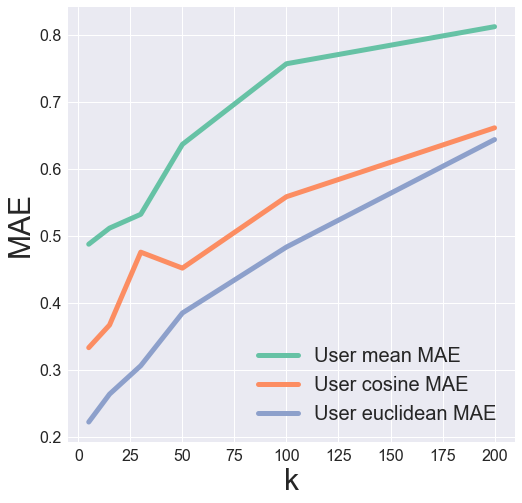

In [21]:
k_array = [5, 15, 30, 50, 100, 200]
user_mean_MAE = []
user_mean_RMSE = []
user_cosine_MAE = []
user_cosine_RMSE = []
user_euc_MAE = []
user_euc_RMSE = []

for k in k_array:
    predicted_user = eval_prediction(users[:2], k, kind = 'user')

    predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]
    
    for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
        if (name == 'mean_rating'):
            user_mean_MAE.append(MAE(predicted_user, 'rating', name))
            user_mean_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_cosine'):
            user_cosine_MAE.append(MAE(predicted_user, 'rating', name))
            user_cosine_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_euclidean'):
            user_euc_MAE.append(MAE(predicted_user, 'rating', name))
            user_euc_RMSE.append(RMSE(predicted_user, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_MAE, c=pal[0], label='User mean MAE', linewidth=5)
plt.plot(k_array, user_cosine_MAE, c=pal[1], label='User cosine MAE', linewidth=5)
plt.plot(k_array, user_euc_MAE, c=pal[2], label='User euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

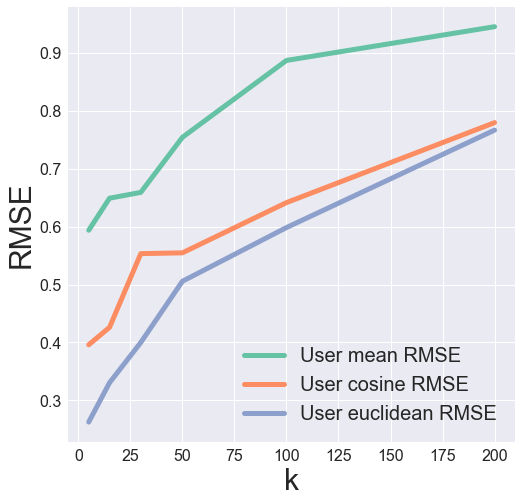

In [22]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_RMSE, c=pal[0], label='User mean RMSE', linewidth=5)
plt.plot(k_array, user_cosine_RMSE, c=pal[1], label='User cosine RMSE', linewidth=5)
plt.plot(k_array, user_euc_RMSE, c=pal[2], label='User euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

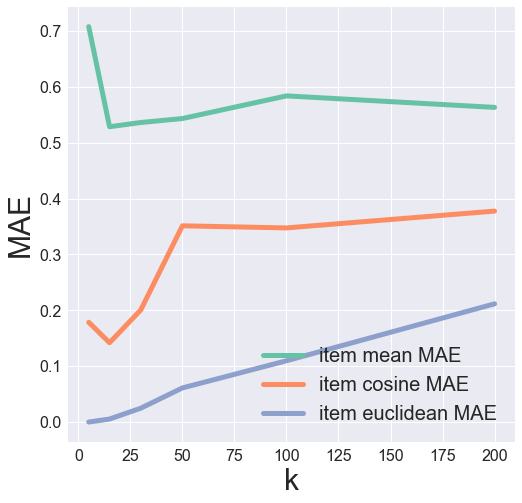

In [38]:
k_array = [5, 15, 30, 50, 100, 200]
item_mean_MAE = []
item_mean_RMSE = []
item_cosine_MAE = []
item_cosine_RMSE = []
item_euc_MAE = []
item_euc_RMSE = []

for k in k_array:
    predicted_item = eval_prediction(users[:2], k, kind = 'item')

    predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]
    
    for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
        if (name == 'mean_rating'):
            item_mean_MAE.append(MAE(predicted_item, 'rating', name))
            item_mean_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_cosine'):
            item_cosine_MAE.append(MAE(predicted_item, 'rating', name))
            item_cosine_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_euclidean'):
            item_euc_MAE.append(MAE(predicted_item, 'rating', name))
            item_euc_RMSE.append(RMSE(predicted_item, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_MAE, c=pal[0], label='item mean MAE', linewidth=5)
plt.plot(k_array, item_cosine_MAE, c=pal[1], label='item cosine MAE', linewidth=5)
plt.plot(k_array, item_euc_MAE, c=pal[2], label='item euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

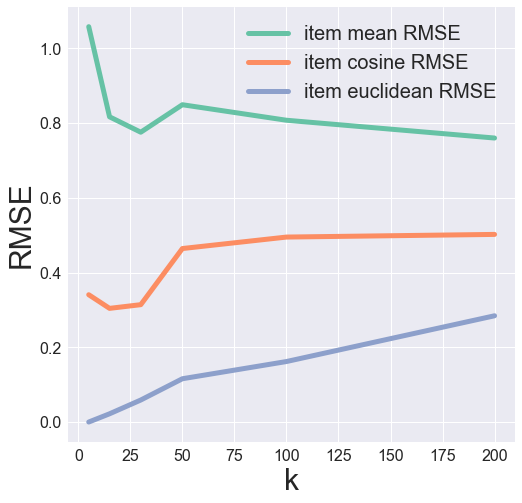

In [39]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_RMSE, c=pal[0], label='item mean RMSE', linewidth=5)
plt.plot(k_array, item_cosine_RMSE, c=pal[1], label='item cosine RMSE', linewidth=5)
plt.plot(k_array, item_euc_RMSE, c=pal[2], label='item euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);